In [1]:
import numpy as np
from PIL import Image
import argparse
import math
from skimage import io
from keras.preprocessing import image
from keras import backend as K
K.set_image_dim_ordering('th')


def load_data2(txt_name):
    path = open('/home/dl/zyfang/face_example/'+txt_name, 'r')
    lines = path.readlines()
    X_train = np.zeros([len(lines), 112, 96, 3])
    for i in range(len(lines)):
        t = lines[i].replace('/media/sdb/ECCV16-SIAT/','/home/dl/zyfang/')
        t = t[0: t.index('.jpg')+4]
        img = io.imread(t)
        if (len(img.shape) == 3):
            X_train[i] = img
    return X_train
def load_data(txt_name):
    path = open('/home/dl/zyfang/face_example/'+txt_name, 'r')
    lines = path.readlines()
    X_train = np.zeros([len(lines), 112, 96, 3])
    for i in range(len(lines)):
        img = io.imread(lines[i].replace('/home/zyfang/caffe-face', '/home/dl/zyfang').replace(' 0\n', ''))
        if (len(img.shape) == 3):
            X_train[i] = img
    return X_train
def downsample(img, size):
    im = np.empty([img.shape[0]/size, img.shape[1]/size, 3])    
    for i in range(im.shape[2]):
        for m in range(im.shape[1]):
            for n in range(im.shape[0]):
                im[n, m, i] = img[size*n, size*m ,i]
    return im.astype(np.uint8)

Using TensorFlow backend.


In [2]:
import Data
X_train, y_train, X_test, y_test = Data.loadData('data.h5')

In [3]:
%matplotlib inline
from matplotlib.pyplot import imshow
from skimage.transform import pyramid_reduce
i=30
#imshow((y_train[i,:,:,:]-127.5)/127.5)
img = y_test[i,:,:,:]

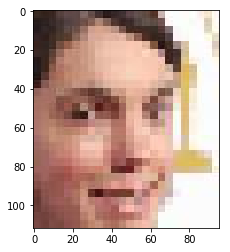

In [15]:
imshow(X_train[10])

In [16]:
X_train[10].shape

(112, 96, 3)

In [ ]:
#     X_train = load_data('lr_training.txt')
#     y_train = load_data2('hr_training.txt')
#     X_test = load_data('lr_val.txt')
#     y_test = load_data2('hr_val.txt')
    # Create the HDF5 file
    f = h5py.File('data.h5', 'w')

    # Create the image and palette dataspaces
    dset = f.create_dataset('lr_train', data=X_train)
    pset = f.create_dataset('hr_train', data=y_train)
    lset = f.create_dataset('lr_test', data = X_test)
    sset = f.create_dataset('hr_test', data = y_test)

    # Close the file
    f.close()

In [ ]:
xtrain = []
ytrain = []
xval = []
yval = []
for i in range(X_train.shape[0]):
    xtrain.append(downsample(y_train[i],4))
    ytrain.append(y_train[i])
for i in range(X_test.shape[0]):
    xval.append(downsample(y_test[i],4))
    yval.append(y_test[i])   
                
xtrain = np.asarray(xtrain)
ytrain = np.asarray(ytrain)
xval = np.asarray(xval)
yval = np.asarray(yval)
import h5py
f = h5py.File('data_small.h5', 'w')

# Create the image and palette dataspaces
dset = f.create_dataset('lr_train', data=xtrain)
pset = f.create_dataset('hr_train', data=ytrain)
lset = f.create_dataset('lr_test', data = xval)
sset = f.create_dataset('hr_test', data = yval)

# Close the file
f.close()

In [4]:
from keras.engine import  Model
from keras.layers import Input
from keras_vggface import VGGFace

In [ ]:
def retrieve_conv_feature(img_list):
    features = []
    image_input = Input(shape=(112, 96, 3))
    vgg_model = VGGFace(input_tensor=image_input, include_top=False) # pooling: None, avg or max
    out = vgg_model.get_layer('pool5').output
    vgg_conv = Model(image_input, out)
    for i in range(len(img_list)):
        x = img_preprocess(img_list[i])
        preds = vgg_conv.predict(x)
        features.append(preds)
    return np.asarray(features)

In [ ]:
def img_preprocess(img):
        img = img.astype(np.float64)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        # TF order aka 'channel-last'
        x = x[:, :, :, ::-1]
        # TH order aka 'channel-first'
        # x = x[:, ::-1, :, :]
        # Zero-center by mean pixel
        x[:, 0, :, :] -= 93.5940
        x[:, 1, :, :] -= 104.7624
        x[:, 2, :, :] -= 129.1863
        return x

In [ ]:
temp = retrieve_conv_feature(y_test[0:20])

In [ ]:
from keras import backend as K

def gram_matrix(x):
    features = K.batch_flatten(x)
    gram = K.dot(features - 1, K.transpose(features - 1))
    return gram

# vgg conv_loss
def conv_loss(style, combination):

    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = 112 * 96
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [ ]:
temp = vgg_model.predict(y_test[0:20])

In [ ]:
y_test[0:20].shape

In [ ]:
# Retrieve feature maps from VGG 
def retrieve_conv_feature(img_list):
    image_input = Input(shape=(112, 96, 3))
    vgg_model = VGGFace(input_tensor=image_input, include_top=False) # pooling: None, avg or max
    out = vgg_model.get_layer('pool5').output
    vgg_conv = Model(image_input, out)
    preds = vgg_conv.predict(img_list)
    return preds



In [ ]:
a = retrieve_conv_feature(y_test[0:20])

In [ ]:
    
    y_train = (y_train.astype(np.float32) - 127.5)/127.5
    print('Data Normalized.')

    #   Reshape the img in the format of (number of rows, channels, height, weight)
    y_train = y_train.reshape((y_train.shape[0], 3) + y_train.shape[1:3])

In [ ]:
from keras import backend as K
K.set_image_dim_ordering('th')

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.core import Flatten
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image
from keras.layers.core import Dropout
from keras.engine import  Model
from keras.layers import Input
from keras_vggface import VGGFace
from scipy.misc import imsave
from Utils import conv_loss, gram_matrix
import numpy as np
from PIL import Image
import argparse
import math
import Data as Data



def cnn_model():
 
    model = Sequential()
    model.add(Flatten(input_shape=(3, 28, 24)))
    model.add(Dense(16*28*24, init='uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu')) 
    model.add(Reshape((16, 28, 24), input_shape=(16*28*24,)))
    model.add(Convolution2D(64, 5, 5, border_mode='same'))
    model.add(Activation('relu'))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Convolution2D(32, 5, 5, border_mode='same'))
    model.add(Activation('relu'))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Convolution2D(16, 5, 5, border_mode='same'))
    model.add(Activation('relu'))
    model.add(Convolution2D(3, 5, 5, border_mode='same'))
    
    return model

def generator_model():
    model = Sequential()
    model.add(Convolution2D(64, 5, 5, border_mode='same', input_shape=(3, 28, 24)))
    model.add(Activation('relu')) 
    model.add(Convolution2D(32, 5, 5, border_mode='same'))
    model.add(Activation('relu'))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Convolution2D(32, 5, 5, border_mode='same'))
    model.add(Activation('relu'))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Convolution2D(16, 5, 5, border_mode='same'))
    model.add(Activation('relu'))
    model.add(Convolution2D(3, 5, 5, border_mode='same'))
    
    return model


def discriminator_model():
    model = Sequential()
    model.add(Convolution2D(
                        16, 5, 5,
                        border_mode='same',
                        input_shape=(3, 112, 96)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Convolution2D(32, 5, 5))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Convolution2D(64, 5, 5))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Convolution2D(96, 5, 5))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Activation('relu'))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    return model


def generator_containing_discriminator(generator, discriminator):
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False
    model.add(discriminator)
    return model

#retrive the first image in predicting set
def combine_images(generated_images):
    generated_images = generated_images.reshape(128,112,96,3)
    image = generated_images[0,:,:,:]
    return image

# Zero-center by mean pixel
def img_preprocess(img):
        img = img.astype(np.float64)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        # TF order aka 'channel-last'
        x = x[:, :, :, ::-1]
        # TH order aka 'channel-first'
        # x = x[:, ::-1, :, :]
        # Zero-center by mean pixel
        x[:, 0, :, :] -= 93.5940
        x[:, 1, :, :] -= 104.7624
        x[:, 2, :, :] -= 129.1863
        return x
    


 # Training supervised by feature layer wise (perceptual similarity)
def train(BATCH_SIZE):
    # load the training data
    print('Data loading..')
    X_train, y_train, X_test, y_test = Data.loadData('data_small.h5')
    print('Data Loaded. Now normalizing..')
    
    X_train = (X_train.astype(np.float32) - 127.5)/127.5
    y_train = (y_train.astype(np.float32) - 127.5)/127.5
    print('Data Normalized.')

    #   Reshape the img in the format of (number of rows, channels, height, weight)
    X_train = X_train.reshape((X_train.shape[0], 3) + X_train.shape[1:3])
    y_train = y_train.reshape((y_train.shape[0], 3) + y_train.shape[1:3])

    discriminator = discriminator_model()
    generator = generator_model()
    discriminator_on_generator = \
        generator_containing_discriminator(generator, discriminator)

        
    d_optim = RMSprop(lr=0.00001, rho=0.9, epsilon=1e-08, decay=0.0)
    g_optim = RMSprop(lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.0)
    generator.compile(loss= conv_loss, optimizer=g_optim)
#    discriminator_on_generator.compile(loss='binary_crossentropy', optimizer=g_optim)
#    discriminator.trainable = True
#    discriminator.compile(loss='binary_crossentropy', optimizer=d_optim)
    noise = np.zeros((BATCH_SIZE, 100))
    shape = []
    for epoch in range(100):
        print("Epoch is", epoch)
        print("Number of batches", int(X_train.shape[0]/BATCH_SIZE))
        for index in range(int(X_train.shape[0]/BATCH_SIZE)):
            # Random Signal Goes here (if needed)
            for i in range(BATCH_SIZE):
                noise[i, :] = np.random.uniform(-1, 1, 100)

            lr_image_batch = X_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
            hr_image_batch = y_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
            generated_images = generator.predict(lr_image_batch, verbose=0)
            shape = generated_images.shape

            if index % 10 == 0:
                image = combine_images(generated_images)
                image = image* 127.5+ 127.5
                imsave("./image_result/"+str(epoch)+"_"+str(index)+".png", image.astype(np.uint8))
            X = np.concatenate((hr_image_batch, generated_images))
            y = [1] * BATCH_SIZE + [0] * BATCH_SIZE
#            d_loss = discriminator.train_on_batch(X, y)
#            print("batch %d d_loss : %f" % (index, d_loss))

#            for i in range(BATCH_SIZE):
#                noise[i, :] = np.random.uniform(-1, 1, 100)
#            discriminator.trainable = False
            
            #retrieve conv_loss of images
            conv_lr_image_batch = retrieve_conv_feature(generated_images.reshape(generated_images.shape[0], generated_images.shape[2],generated_images.shape[3] ,3))
            conv_hr_image_batch = retrieve_conv_feature(hr_image_batch.reshape(hr_image_batch.shape[0], hr_image_batch.shape[2],hr_image_batch.shape[3] ,3))
            
            #g_loss = 0.1* discriminator_on_generator.train_on_batch( lr_image_batch, [1] * BATCH_SIZE) 
            g_loss = generator.train_on_batch(conv_lr_image_batch, conv_hr_image_batch)
#            discriminator.trainable = True
            print("batch %d g_loss : %f" % (index, g_loss))
#            print(shape)
            if index % 10 == 9:
                generator.save_weights('generator', True)
#                discriminator.save_weights('discriminator', True)
   

 # Training in MSE loss function (pixel wise training)
def MSE(BATCH_SIZE):
    # load the training data
    print('Data loading..')
    X_train, y_train, X_test, y_test = Data.loadData('data_small.h5')
    print('Data Loaded. Now normalizing..')
    
    X_train = (X_train.astype(np.float32) - 127.5)/127.5
    y_train = (y_train.astype(np.float32) - 127.5)/127.5
    print('Data Normalized.')

    #   Reshape the img in the format of (number of rows, channels, height, weight)
    X_train = X_train.reshape((X_train.shape[0], 3) + X_train.shape[1:3])
    y_train = y_train.reshape((y_train.shape[0], 3) + y_train.shape[1:3])

    discriminator = discriminator_model()
    generator = generator_model()
    discriminator_on_generator = \
        generator_containing_discriminator(generator, discriminator)

        
    d_optim = RMSprop(lr=0.00001, rho=0.9, epsilon=1e-08, decay=0.0)
    g_optim = RMSprop(lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.0)
    generator.compile(loss='mean_squared_error', optimizer=g_optim)
    discriminator_on_generator.compile(
        loss='binary_crossentropy', optimizer=g_optim)
    discriminator.trainable = True
    discriminator.compile(loss='binary_crossentropy', optimizer=d_optim)
    noise = np.zeros((BATCH_SIZE, 100))
    shape = []
    for epoch in range(100):
        print("Epoch is", epoch)
        print("Number of batches", int(X_train.shape[0]/BATCH_SIZE))
        for index in range(int(X_train.shape[0]/BATCH_SIZE)):
            # Random Signal Goes here (if needed)
            for i in range(BATCH_SIZE):
                noise[i, :] = np.random.uniform(-1, 1, 100)

            lr_image_batch = X_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
            hr_image_batch = y_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
            generated_images = generator.predict(lr_image_batch, verbose=0)
            shape = generated_images.shape

            if index % 10 == 0:
                image = combine_images(generated_images)
                image = image* 127.5+ 127.5
                imsave("./image_result/"+str(epoch)+"_"+str(index)+".png", image.astype(np.uint8))
            X = np.concatenate((hr_image_batch, generated_images))
            y = [1] * BATCH_SIZE + [0] * BATCH_SIZE
            d_loss = discriminator.train_on_batch(X, y)
            print("batch %d d_loss : %f" % (index, d_loss))

            for i in range(BATCH_SIZE):
                noise[i, :] = np.random.uniform(-1, 1, 100)
            discriminator.trainable = False
            

            g_loss = discriminator_on_generator.train_on_batch(
               lr_image_batch, [1] * BATCH_SIZE)
            # generator.train_on_batch(lr_image_batch, hr_image_batch)
            discriminator.trainable = True
            print("batch %d g_loss : %f" % (index, g_loss))
#            print(shape)
            if index % 10 == 9:
                generator.save_weights('generator', True)
                discriminator.save_weights('discriminator', True)
                
                
# def generate(BATCH_SIZE, nice=False):
#     generator = generator_model()
#     generator.compile(loss='binary_crossentropy', optimizer="SGD")
#     generator.load_weights('generator')
#     if nice:
#         discriminator = discriminator_model()
#         discriminator.compile(loss='binary_crossentropy', optimizer="SGD")
#         discriminator.load_weights('discriminator')
#         noise = np.zeros((BATCH_SIZE*20, 100))
#         for i in range(BATCH_SIZE*20):
#             noise[i, :] = np.random.uniform(-1, 1, 100)
#         generated_images = generator.predict(noise, verbose=1)
#         d_pret = discriminator.predict(generated_images, verbose=1)
#         index = np.arange(0, BATCH_SIZE*20)
#         index.resize((BATCH_SIZE*20, 1))
#         pre_with_index = list(np.append(d_pret, index, axis=1))
#         pre_with_index.sort(key=lambda x: x[0], reverse=True)
#         nice_images = np.zeros((BATCH_SIZE, 1) +
#                                (generated_images.shape[2:]), dtype=np.float32)
#         for i in range(int(BATCH_SIZE)):
#             idx = int(pre_with_index[i][1])
#             nice_images[i, 0, :, :] = generated_images[idx, 0, :, :]
#         image = combine_images(nice_images)
#     else:
#         noise = np.zeros((BATCH_SIZE, 100))
#         for i in range(BATCH_SIZE):
#             noise[i, :] = np.random.uniform(-1, 1, 100)
#         generated_images = generator.predict(noise, verbose=1)
#         image = combine_images(generated_images)
#     image = image*127.5+127.5
#     Image.fromarray(image.astype(np.uint8)).save(
# #         "./image_result/generated_image.png")







In [ ]:
    
    # load the training data
    print('Data loading..')
    X_train, y_train, X_test, y_test = Data.loadData('data_small.h5')
    print('Data Loaded. Now normalizing..')
    
    X_train = (X_train.astype(np.float32) - 127.5)/127.5
    y_train = (y_train.astype(np.float32) - 127.5)/127.5
    print('Data Normalized.')

    #   Reshape the img in the format of (number of rows, channels, height, weight)
    X_train = X_train.reshape((X_train.shape[0], 3) + X_train.shape[1:3])
    y_train = y_train.reshape((y_train.shape[0], 3) + y_train.shape[1:3])

    discriminator = discriminator_model()
    generator = generator_model()
    discriminator_on_generator = \
        generator_containing_discriminator(generator, discriminator)

        
    d_optim = RMSprop(lr=0.00001, rho=0.9, epsilon=1e-08, decay=0.0)
    g_optim = RMSprop(lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.0)
    generator.compile(loss= conv_loss, optimizer=g_optim)
#    discriminator_on_generator.compile(loss='binary_crossentropy', optimizer=g_optim)
#    discriminator.trainable = True
#    discriminator.compile(loss='binary_crossentropy', optimizer=d_optim)
    shape = []

    index =1
    BATCH_SIZE = 128
    lr_image_batch = X_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
    hr_image_batch = y_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
    generated_images = generator.predict(lr_image_batch, verbose=0)
    shape = generated_images.shape

    if index % 10 == 0:
        image = combine_images(generated_images)
        image = image* 127.5+ 127.5
        imsave("./image_result/"+str(epoch)+"_"+str(index)+".png", image.astype(np.uint8))
    X = np.concatenate((hr_image_batch, generated_images))
    y = [1] * BATCH_SIZE + [0] * BATCH_SIZE
#            d_loss = discriminator.train_on_batch(X, y)
#            print("batch %d d_loss : %f" % (index, d_loss))

#            for i in range(BATCH_SIZE):
#                noise[i, :] = np.random.uniform(-1, 1, 100)
#            discriminator.trainable = False


   

In [ ]:
temp = generated_images.reshape(generated_images.shape[0], generated_images.shape[2],generated_images.shape[3] ,3)

In [ ]:
temp.shape

In [ ]:
# Retrieve feature maps from VGG 
def retrieve_conv_feature(img_list):
    image_input = Input(shape=(112, 96, 3))
    vgg_model = VGGFace(input_tensor=image_input, include_top=False) # pooling: None, avg or max
    out = vgg_model.get_layer('pool5').output
    vgg_conv = Model(image_input, out)
    preds = vgg_conv.predict(img_list)
    return preds

In [ ]:
a = retrieve_conv_feature(y_test[0:20])

In [ ]:
    image_input = Input(shape=(112, 96, 3))
    vgg_model = VGGFace(input_tensor=image_input, include_top=False) # pooling: None, avg or max
    out = vgg_model.get_layer('pool5').output


In [ ]:
    features = []
    img_list = y_test[0:20]
    image_input = Input(shape=(112, 96, 3))
    vgg_model = VGGFace(input_tensor=image_input, include_top=False) # pooling: None, avg or max
    out = vgg_model.get_layer('pool5').output
    vgg_conv = Model(image_input, out)
    for i in range(len(img_list)):
        x = img_preprocess(img_list[i])
        preds = vgg_conv.predict(x)
        features.append(preds)

In [5]:
        image_input = Input(shape=(112, 96, 3))
        vgg_model = VGGFace(input_tensor=image_input, include_top=False) # pooling: None, avg or max
        out = vgg_model.get_layer('pool5').output
        vgg_conv = Model(image_input, out)

In [15]:
from keras import backend as K
K.set_image_dim_ordering('th')

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.core import Flatten
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image
from keras.layers.core import Dropout
from keras.engine import  Model
from keras.layers import Input
from keras_vggface import VGGFace
from scipy.misc import imsave
from Utils import conv_loss, gram_matrix
import numpy as np
from PIL import Image
import argparse
import math
import Data as Data


#srcnn_vgg combine
def cnn_model():
 
    model = Sequential()
    model.add(Flatten(input_shape=(3, 28, 24)))
    model.add(Dense(16*28*24, init='uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu')) 
    model.add(Reshape((16, 28, 24), input_shape=(16*28*24,)))
    model.add(Convolution2D(64, 5, 5, border_mode='same'))
    model.add(Activation('relu'))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Convolution2D(32, 5, 5, border_mode='same'))
    model.add(Activation('relu'))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Convolution2D(16, 5, 5, border_mode='same'))
    model.add(Activation('relu'))
    model.add(Convolution2D(3, 5, 5, border_mode='same'))
    
    return model


def generator_containing_discriminator(generator, discriminator):
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False
    model.add(discriminator)
    return model

#retrive the first image in predicting set
def combine_images(generated_images):
    generated_images = generated_images.reshape(128,112,96,3)
    image = generated_images[0,:,:,:]
    return image


BATCH_SIZE = 128
# load the training data
print('Data loading..')
X_train, y_train, X_test, y_test = Data.loadData('data_small.h5')
print('Data Loaded. Now normalizing..')

X_train = (X_train.astype(np.float32) - 127.5)/127.5
y_train = (y_train.astype(np.float32) - 127.5)/127.5
print('Data Normalized.')

#   Reshape the img in the format of (number of rows, channels, height, weight)
X_train = X_train.reshape((X_train.shape[0], 3) + X_train.shape[1:3])
y_train = y_train.reshape((y_train.shape[0], 3) + y_train.shape[1:3])

#vgg model goes here
image_input = Input(shape=(3, 112, 96))
vgg_model = VGGFace(input_tensor=image_input, include_top=False, pooling='avg') # pooling: None, avg or max
out = vgg_model.get_layer('pool5').output
vgg_conv = Model(image_input, out)

#generator model goes here
generator = cnn_model()
generator_vgg = \
        generator_containing_discriminator(generator, vgg_conv)
    
d_optim = RMSprop(lr=0.00001, rho=0.9, epsilon=1e-08, decay=0.0)
g_optim = RMSprop(lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.0)

generator.compile(loss='mean_squared_error', optimizer=g_optim)
generator_vgg.compile(
    loss=conv_loss, optimizer=g_optim)

for epoch in range(100):
    print("Epoch is", epoch)
    print("Number of batches", int(X_train.shape[0]/BATCH_SIZE))
    for index in range(int(X_train.shape[0]/BATCH_SIZE)):
        lr_image_batch = X_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
        hr_image_batch = y_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
        generated_images = generator.predict(lr_image_batch, verbose=0)
        shape = generated_images.shape

        if index % 10 == 0:
            image = combine_images(generated_images)
            image = image* 127.5+ 127.5
            imsave("./image_result/"+str(epoch)+"_"+str(index)+".png", image.astype(np.uint8))
        X = np.concatenate((hr_image_batch, generated_images))
        y = [1] * BATCH_SIZE + [0] * BATCH_SIZE
        
        #generate feature labels for the hr_images
        labels = vgg_conv.predict(hr_image_batch)
        
        g_loss = generator_vgg.train_on_batch(lr_image_batch, labels)

        print("batch %d g_loss : %f" % (index, g_loss))
        if index % 10 == 9:
            generator.save_weights('generator', True)


Data loading..
Data Loaded. Now normalizing..
Data Normalized.


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:32: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10752, kernel_initializer="uniform")`
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:36: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), padding="same")`
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:39: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), padding="same")`
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:42: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (5, 5), padding="same")`
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:44: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (5, 5), padding="same")`


('Epoch is', 0)
('Number of batches', 659)
batch 0 g_loss : 0.008772
batch 1 g_loss : 0.018026
batch 2 g_loss : 0.005628
batch 3 g_loss : 0.001622
batch 4 g_loss : 0.001526
batch 5 g_loss : 0.002980
batch 6 g_loss : 0.003342
batch 7 g_loss : 0.002066


KeyboardInterrupt: 